In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
#import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

import GOSTnet as gn
from make_fishnet import make_fishnet

Populating the interactive namespace from numpy and matplotlib
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


In [2]:
fig_kwargs={'figsize': [10, 10]}
bmap_kwargs={'suppress_ticks': False,'epsg': '4326'}
plot_kwargs={'cmap': 'viridis', 's': 8, 'edgecolor': 'none'}
hex_plot_kwargs = {'gridsize':40,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

## Mapping pedestrian accessibility

#### 1. Get bounding box from geocoder

In [3]:
Gk = ox.graph_from_place('Ulaan Baatar')

In [4]:
Gk.number_of_nodes()

27696

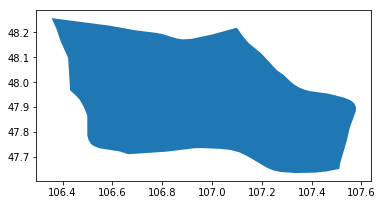

In [5]:
boundary_GDF = ox.gdf_from_place("Ulaan Baatar")
boundary_GDF.plot()

In [6]:
boundary_poly = boundary_GDF.loc[0,'geometry']
coords = (boundary_poly.bounds[1], boundary_poly.bounds[0], boundary_poly.bounds[3], boundary_poly.bounds[2])
coords

(47.635288, 106.356383, 48.257157, 107.578164)

In [6]:
coords_custom = (47.4,106.25,48.4,107.5)

#### 2. Get POIs, road network and fishnet
format: osm.node_query(lat_min, lng_min, lat_max, lng_max, tags=None)

In [7]:
pois_business = pd.read_csv('pois_business.csv')
pois_business = gpd.GeoDataFrame(pois_business)

pois_res = pd.read_csv('pois_res.csv')
pois_res = gpd.GeoDataFrame(pois_res)

In [8]:
pois_business['geometry'] = (list(zip(pois_business.lon,pois_business.lat)))
pois_business['geometry'] = pois_business.geometry.apply(lambda x: Point(x))

pois_res['geometry'] = (list(zip(pois_res.lon,pois_res.lat)))
pois_res['geometry'] = pois_res.geometry.apply(lambda x: Point(x))

pois_res = pois_res[pois_res['type'] != 'bank']

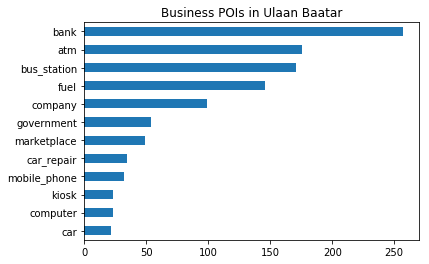

In [15]:
pois_business['type'].value_counts()[:12].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Business POIs in Ulaan Baatar');

In [7]:
network = osm.pdna_network_from_bbox(coords[0], coords[1], coords[2], coords[3], network_type='drive')

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](47.63528800,106.35636311,47.95668634,106.97096010);>;);out;'}"
Downloaded 5,501.7KB from www.overpass-api.de in 3.59 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](47.94778142,106.35636311,48.25877948,106.98288991);>;);out;'}"
Downloaded 4,166.6KB from www.

In [17]:
nodes_gdf = gpd.GeoDataFrame(network.nodes_df)
nodes_gdf['geometry'] = (list(zip(nodes_gdf.x,nodes_gdf.y)))
nodes_gdf['geometry'] = nodes_gdf.geometry.apply(lambda x: Point(x))

In [39]:
make_fishnet('grid_.shp',coords_custom[1], coords_custom[3], coords_custom[0], coords_custom[2],250,250) # takes xmin, xmax, ymin, ymax

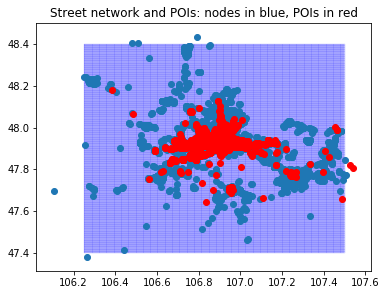

In [18]:
grid=gpd.read_file('grid_.shp')
ax = grid.plot(facecolor='w',edgecolor='b',lw=0.1,figsize=[6,6])
nodes_gdf.plot(ax=ax)
pois_res.plot(ax=ax,color='r')
ax.set_title('Street network and POIs: nodes in blue, POIs in red');

#### 3. Plot accessibility from any node to nearest amenity

In [25]:
network.precompute(2000) # precomputes the nodes that are reachable within 2000 meters

Variables to define:
 - distance: compute accessibility within this distance from any point
 - num_pois: calculate distance to this many amenities [ie. to first, second, third ... n amenities]

In [26]:
distance = 2000
num_pois = 5
#num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

In [27]:
network.set_pois(category='all', maxdist = distance,maxitems = num_pois,x_col=pois_business['lon'], y_col=pois_business['lat'])

all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

all_access.head(5)

,1,2,3,4,5
id,,,,,
57677289,0.000000,22.584999,22.584999,81.661003,128.126007
57677290,0.000000,81.156998,108.393997,108.393997,108.393997
57677291,0.000000,0.000000,0.000000,0.000000,0.000000
200776606,10.054000,101.959999,116.478996,269.895996,269.895996
200777167,97.891998,109.411003,158.654007,158.654007,158.654007


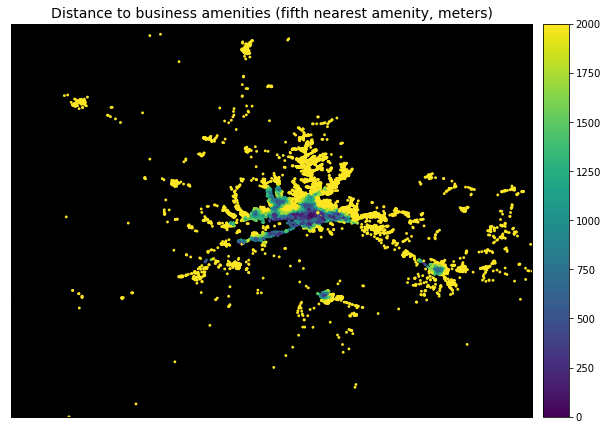

In [29]:
# distance to the nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
ax.set_title('Distance to business amenities (fifth nearest amenity, meters)', fontsize=14);

In [51]:
# Do it for residential amenities

network.set_pois(category='all', maxdist = distance,maxitems = num_pois,x_col=pois_res['lon'], y_col=pois_res['lat'])

all_access_res = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

#### 4. Fix the distances to the grid

In [30]:
grid['nearest_node'] = np.nan
grid['nearest_node'] = network.get_node_ids(grid.centroid.x,grid.centroid.y,mapping_distance=5)

In [31]:
grid.head(2)

,FID,geometry,nearest_node
0,0,"POLYGON ((106.25 48.4, 106.2522457882103 48.4,...",1754035151
1,1,"POLYGON ((106.25 48.39668212743414, 106.252245...",1754035151


In [32]:
distances = []
for i in range(grid.shape[0]):
    node = grid.nearest_node[i]
    distance = all_access.loc[node,5]
    distances.append(distance) 
    
grid['distances'] = distances

In [52]:
distances = []
for i in range(grid.shape[0]):
    node = grid.nearest_node[i]
    distance = all_access_res.loc[node,5]
    distances.append(distance) 
    
grid['distances_res'] = distances

[Text(0.5, 1.0, 'Ulaan Baatar: Meters walk to fifth-nearest business amenity')]

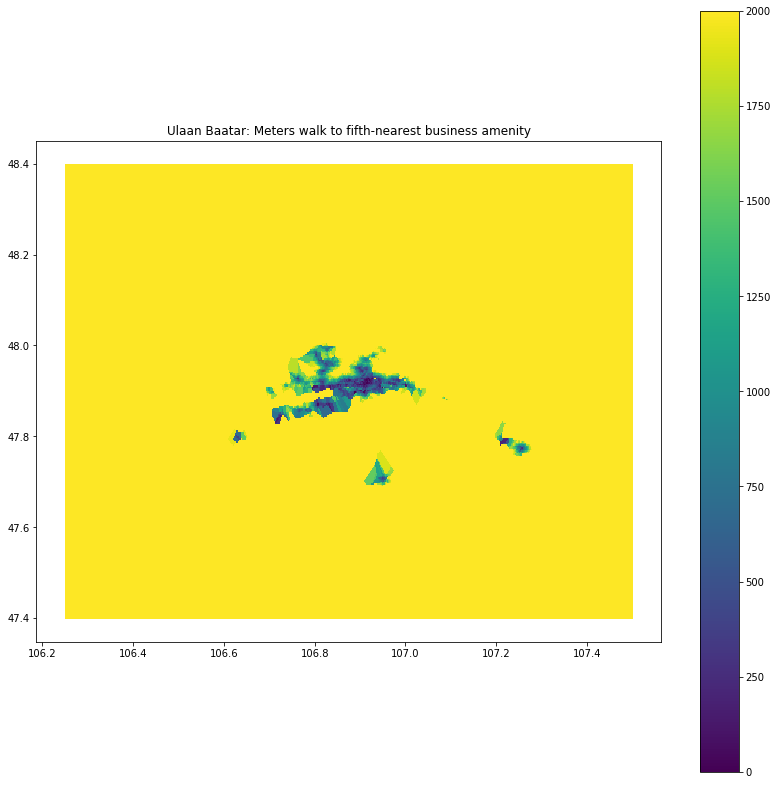

In [48]:
city = 'Ulaan Baatar'
ax = grid.plot(column='distances',figsize=[14,14],legend=True)
ax.set(title = '{}: Meters walk to fifth-nearest business amenity'.format(city))

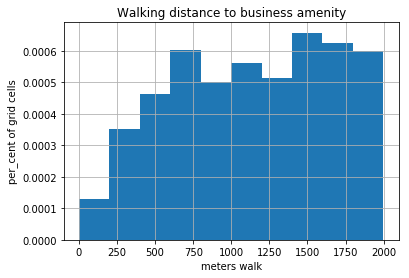

In [35]:
f,ax = plt.subplots()
grid.distances[grid.distances<2000].hist(ax=ax,normed = True)
plt.title('Walking distance to business amenity')
ax.set(ylabel="per_cent of grid cells", xlabel='meters walk');

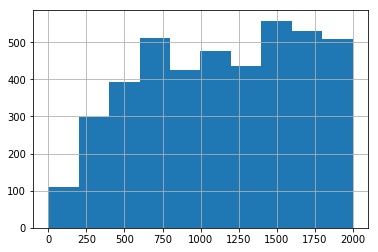

In [69]:
grid.distances[grid.distances<2000].hist()

In [59]:
grid.to_csv('UB_grid_csv')

In [72]:
grid.to_file('UB_grid')

In [74]:
a = gpd.read_file('UB_grid/UB_grid.shp')
a.columns

Index(['FID', 'nearest_no', 'distances', 'distances_', 'geometry'], dtype='object')

In [71]:
grid.columns

Index(['FID', 'geometry', 'nearest_node', 'distances', 'distances_res'], dtype='object')